## TCN Inference
---

Use this notebook to conduct inference with TCN, for organizing purpose.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime 
import seaborn as sns
import torch

import TCNs

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
import feather

%load_ext autoreload
%autoreload 2

#### Load Data

In [2]:
modeling_df_trans = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_trans.feather")
modeling_df_acct = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_acct.feather")
df_train_trans = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/df_train_trans.feather")
df_test_trans = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/df_test_trans.feather")
modeling_df_acct_with_full_validation = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_acct_with_full_validation_preds.feather")
modeling_df_trans_with_full_validation = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_trans_with_full_validation_preds.feather")

#### Load Train-Valid Model

In [6]:
features = ['nr_past_transactions',
            'card_present_ind',
            'has_transaction_comment',
            'hr_of_transaction',
            'international_transaction_flag',
            'transaction_code',
            'transaction_type',
            'days_since_first_transaction',
            'transaction_as_pct_of_balance',
            'target',
            'borrower_id',
            'index']

In [ ]:
# load and infer!
%time tcn = torch.load("../model/v2_TCN_CLF_TRANS_basic_best_validation/tcn.pth", map_location=lambda storage, loc: storage)
%time tcn.set_params(device='cuda:0')
%time test_data = tcn.process_data_inference(modeling_df_trans, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])

# if infer on the full dataset
%time preds = tcn.predict_proba(test_data, return_sequences=True)

# merge with full dataset
modeling_df_trans = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_trans.feather")
inference_pred = pd.merge(preds, modeling_df_trans, on=['index', 'borrower_id'], how='inner')
inference_pred.head()

#### Load Final Model
---

In [29]:
%time tcn_full = torch.load("../model/v2_TCN_CLF_TRANS_basic_trained_on_all_data/tcn.pth", map_location=lambda storage, loc: storage) # will go with this one

CPU times: user 48.1 ms, sys: 4.01 ms, total: 52.2 ms
Wall time: 51.6 ms


In [30]:
%time modeling_df = modeling_df_trans[features].copy()
%time test_data = tcn_full.process_data_inference(modeling_df, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])
%time tcn_preds = tcn_full.predict_proba(test_data, return_sequences=True)

CPU times: user 160 ms, sys: 145 ms, total: 305 ms
Wall time: 173 ms
data processed!
CPU times: user 45.8 s, sys: 538 ms, total: 46.3 s
Wall time: 46 s
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
CPU times: user 1min, sys: 21.9 s, total: 1min 22s
Wall time: 48.3 s


In [34]:
modeling_df_trans = pd.merge(tcn_preds, modeling_df_trans, on=['index', 'borrower_id'], how='inner')

In [31]:
def plot_pr_curve(y_test, y_score):
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_score)
    
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP = {}'.format(str(average_precision)))

In [82]:
modeling_df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817174 entries, 191026 to 331779
Data columns (total 24 columns):
index                             817174 non-null float64
borrower_id                       817174 non-null int64
tcn_pred                          817174 non-null float64
nr_past_returns                   817174 non-null float64
nr_past_transactions              817174 non-null float64
nr_pos_transactions               817174 non-null float64
nr_atm_transactions               817174 non-null float64
nr_direct_deposits                817174 non-null float64
rolling_trns_as_pct_of_bal        817174 non-null float64
rolling_mean_acc_bal              817174 non-null float64
nr_transactions_per_day           817174 non-null float64
transaction_as_pct_of_bal_min     817174 non-null float64
transaction_as_pct_of_balance     817174 non-null float64
card_present_ind                  817174 non-null float64
has_transaction_comment           817174 non-null float64
hr_of_transactio

### Merge and Output
---

In [38]:
df = pd.read_csv('s3://sofi-data-science/tboser/customer-risk-data/2019-07-23-customer-risk-modeling-df.csv')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097100 entries, 0 to 2097099
Data columns (total 48 columns):
user_id                               int64
borrower_id                           int64
reporting_date_id                     int64
account_closed_date                   object
account_closed_reason                 object
account_restricted_reason             object
date_of_birth                         object
fico_score                            float64
vantage_score                         float64
iqt9415                               float64
all7120                               float64
mtf5820                               float64
bcc7120                               float64
bcc2800                               float64
iln5520                               float64
bcx3423                               float64
use0300                               float64
use8220                               float64
stu5031                               float64
reporting_date         

In [61]:
# account level data
df['borrower_id'] = df['borrower_id'].astype(int)
df['reporting_date'] = pd.to_datetime(df['reporting_date'])
modeling_df_trans['borrower_id'] = modeling_df_trans['borrower_id'].astype(int)
modeling_df_trans.sort_values(['index', 'transaction_datetime'], inplace=True)
df_acct = pd.merge_asof(df[df.columns[~df.columns.isin(['transaction_datetime'])]], 
                        modeling_df_trans[['tcn_pred',
                                         'index',
                                         'borrower_id', 
                                         'transaction_datetime']], left_on='reporting_date', right_on='transaction_datetime', by='borrower_id')

df_acct['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df_acct['age'] = (pd.datetime.today() - df_acct['date_of_birth']).dt.days

modeling_df_acct = df_acct[~df_acct['latest_acc_bal'].isna() & ~df_acct['is_indeterminate']]
modeling_df_acct = modeling_df_acct.drop_duplicates(subset=['borrower_id', 'reporting_date_id'], keep='first')

In [62]:
modeling_df_acct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096968 entries, 0 to 2097099
Data columns (total 50 columns):
user_id                               int64
borrower_id                           int64
reporting_date_id                     int64
account_closed_date                   object
account_closed_reason                 object
account_restricted_reason             object
date_of_birth                         datetime64[ns]
fico_score                            float64
vantage_score                         float64
iqt9415                               float64
all7120                               float64
mtf5820                               float64
bcc7120                               float64
bcc2800                               float64
iln5520                               float64
bcx3423                               float64
use0300                               float64
use8220                               float64
stu5031                               float64
reporting_date 

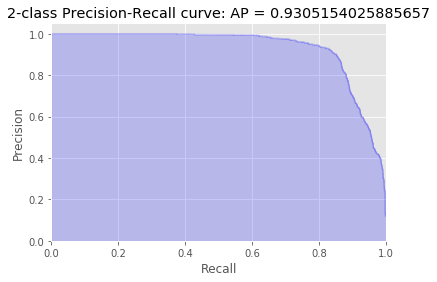

In [78]:
df_tmp = modeling_df_acct[~modeling_df_acct.tcn_pred.isna()]
plot_pr_curve(df_tmp.target, df_tmp.tcn_pred)

In [65]:
# output to this location
modeling_df_acct.reset_index(drop=True).to_feather("../data/TCN_CLF_customer_risk_score/inferred_on_full/modeling_df.feather")

#### Train-Valid datasets

In [71]:
modeling_df_acct_with_full_validation = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_acct_with_full_validation_preds.feather")
df_train_acct = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/df_train_acct.feather")
df_test_acct = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/df_test_acct.feather")

In [72]:
df_train_acct = modeling_df_acct_with_full_validation[modeling_df_acct_with_full_validation.borrower_id.isin(df_train_acct.borrower_id.unique())]
df_test_acct = modeling_df_acct_with_full_validation[modeling_df_acct_with_full_validation.borrower_id.isin(df_test_acct.borrower_id.unique())]

In [75]:
df_train_acct.reset_index(drop=True).to_feather("../data/TCN_CLF_customer_risk_score/inferred_on_full/df_train_acct.feather")
df_test_acct.reset_index(drop=True).to_feather("../data/TCN_CLF_customer_risk_score/inferred_on_full/df_test_acct.feather")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817174 entries, 191026 to 331779
Data columns (total 24 columns):
index                             817174 non-null float64
borrower_id                       817174 non-null int64
tcn_pred                          817174 non-null float64
nr_past_returns                   817174 non-null float64
nr_past_transactions              817174 non-null float64
nr_pos_transactions               817174 non-null float64
nr_atm_transactions               817174 non-null float64
nr_direct_deposits                817174 non-null float64
rolling_trns_as_pct_of_bal        817174 non-null float64
rolling_mean_acc_bal              817174 non-null float64
nr_transactions_per_day           817174 non-null float64
transaction_as_pct_of_bal_min     817174 non-null float64
transaction_as_pct_of_balance     817174 non-null float64
card_present_ind                  817174 non-null float64
has_transaction_comment           817174 non-null float64
hr_of_transactio

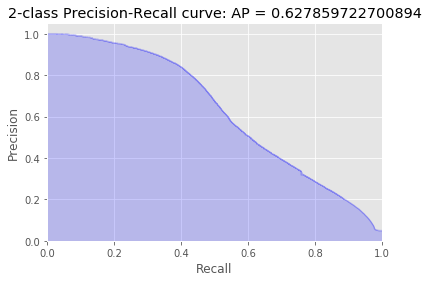

In [81]:
plot_pr_curve(modeling_df_trans.target, modeling_df_trans.tcn_pred)
modeling_df_trans.info()

### Select the model to use
---
For this task, I trained 5 models. Now lets load back the train-validation version, visualize the metrics, and pick the model (trained on full data) that's the closest to valiation

In [106]:
def get_loss(tcn_object):
    import copy
    train_losses = copy.deepcopy(tcn_object.criterion.train_losses)
    test_losses = copy.deepcopy(tcn_object.criterion.test_losses)
#     if hasattr(tcn_object.criterion, 'test_losses'):
#         return (train_losses, test_losses)
    if len(test_losses) > 0:
        return (train_losses, test_losses)
    return (train_losses)


def plot_result(lst_iter, train_metric, test_metric=None, label='metric', title=None, ylim=(0,1)):
    plt.plot(lst_iter, train_metric, label='train {}'.format(label))
    if test_metric is not None:
        plt.plot(lst_iter, test_metric, label='test {}'.format(label))

    plt.xlabel("n epoch")
    plt.legend()
    if title:
        plt.title(title)
    plt.ylim(ylim)
    
    plt.show()

In [107]:
%time tcn = torch.load("../model/v2_TCN_CLF_TRANS_basic_best_validation/tcn.pth", map_location=lambda storage, loc: storage)

CPU times: user 36.4 ms, sys: 8.14 ms, total: 44.5 ms
Wall time: 44.1 ms


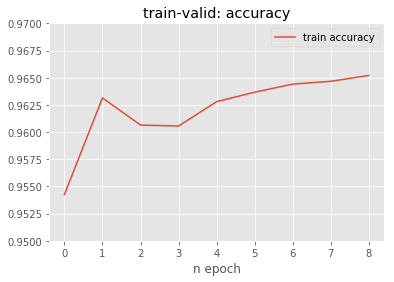

In [134]:
lst_iter = np.linspace(0, 9, 9, endpoint=False)
train_acc = tcn.train_metrics.get_metrics()['accuracy_list']
plot_result(lst_iter, train_acc, label='accuracy', title='train-valid: accuracy', ylim=(0.95, 0.97))

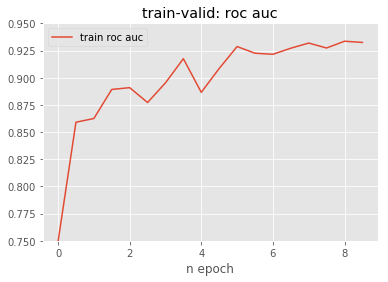

In [135]:
lst_iter = np.linspace(0, 9, 18, endpoint=False)
train_auc = tcn.train_metrics.get_metrics()['roc_auc_list']
plot_result(lst_iter, train_auc, label='roc auc', title='train-valid: roc auc', ylim=(0.75, 0.95))

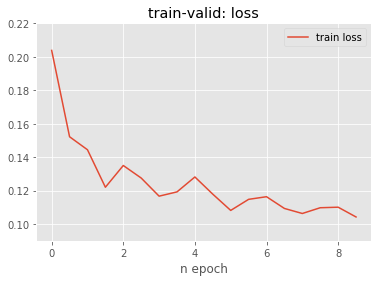

In [138]:
lst_iter = np.linspace(0, 9, 18, endpoint=False)
train_loss, test_loss = get_loss(tcn)
plot_result(lst_iter, train_loss, label='loss', title='train-valid: loss', ylim=(0.09, 0.22))

In [118]:
# full
%time tcn_full_3 = torch.load("../model/TCN_CLF_TRANS_basic_3/tcn.pth", map_location=lambda storage, loc: storage)
%time tcn_full_4 = torch.load("../model/TCN_CLF_TRANS_basic_4/tcn.pth", map_location=lambda storage, loc: storage)
%time tcn_full_5 = torch.load("../model/TCN_CLF_TRANS_basic_5/tcn.pth", map_location=lambda storage, loc: storage)
%time tcn_full_6 = torch.load("../model/TCN_CLF_TRANS_basic_6/tcn.pth", map_location=lambda storage, loc: storage)
%time tcn_full_7 = torch.load("../model/TCN_CLF_TRANS_basic_7/tcn.pth", map_location=lambda storage, loc: storage)

CPU times: user 159 ms, sys: 3.94 ms, total: 163 ms
Wall time: 163 ms
CPU times: user 45.9 ms, sys: 3.97 ms, total: 49.8 ms
Wall time: 49.7 ms
CPU times: user 41.4 ms, sys: 8.01 ms, total: 49.5 ms
Wall time: 49.3 ms
CPU times: user 42.2 ms, sys: 8.16 ms, total: 50.4 ms
Wall time: 50.4 ms
CPU times: user 42.7 ms, sys: 12.2 ms, total: 55 ms
Wall time: 54.5 ms


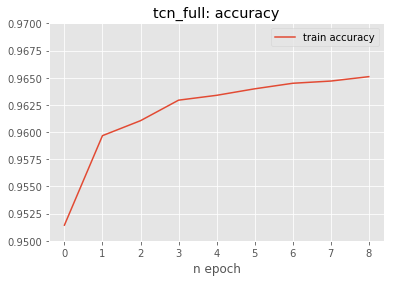

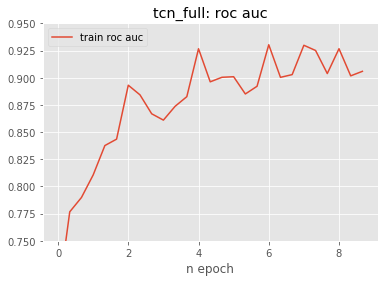

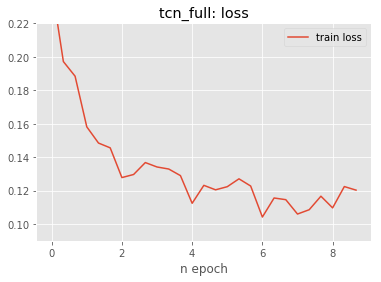

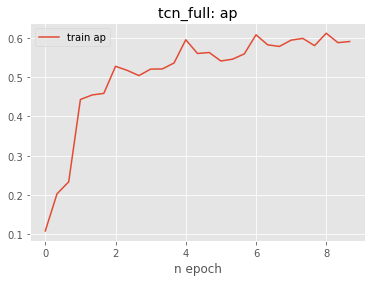

In [151]:
tcn_tmp = tcn_full_3
lst_iter = np.linspace(0, 9, 9, endpoint=False,)
train_acc = tcn_tmp.train_metrics.get_metrics()['accuracy_list']
plot_result(lst_iter, train_acc, label='accuracy', title='tcn_full: accuracy', ylim=(0.95, 0.97))
lst_iter = np.linspace(0, 9, 27, endpoint=False)
train_auc = tcn_tmp.train_metrics.get_metrics()['roc_auc_list']
plot_result(lst_iter, train_auc, label='roc auc', title='tcn_full: roc auc', ylim=(0.75, 0.95))
lst_iter = np.linspace(0, 9, 27, endpoint=False)
train_loss = get_loss(tcn_tmp)
plot_result(lst_iter, train_loss, label='loss', title='tcn_full: loss', ylim=(0.09, 0.22))
train_ap = tcn_tmp.train_metrics.average_precision_list
plot_result(lst_iter, train_ap, label='ap', title='tcn_full: ap', ylim=None)

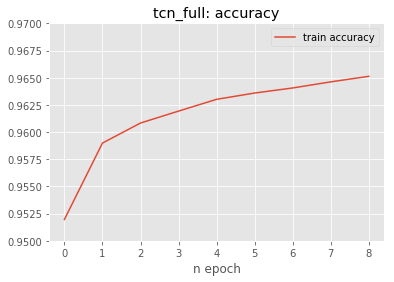

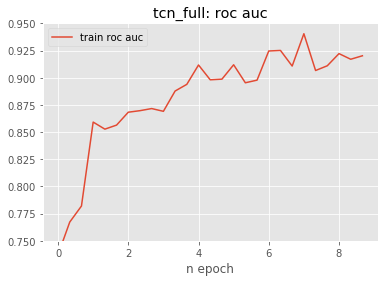

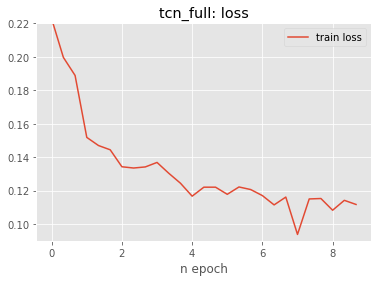

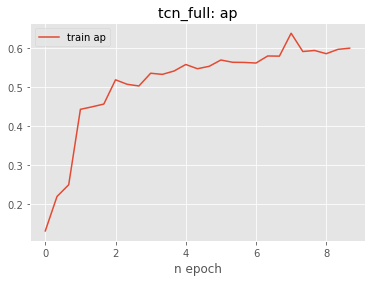

In [152]:
tcn_tmp = tcn_full_4
lst_iter = np.linspace(0, 9, 9, endpoint=False)
train_acc = tcn_tmp.train_metrics.get_metrics()['accuracy_list']
plot_result(lst_iter, train_acc, label='accuracy', title='tcn_full: accuracy', ylim=(0.95, 0.97))
lst_iter = np.linspace(0, 9, 27, endpoint=False)
train_auc = tcn_tmp.train_metrics.get_metrics()['roc_auc_list']
plot_result(lst_iter, train_auc, label='roc auc', title='tcn_full: roc auc', ylim=(0.75, 0.95))
lst_iter = np.linspace(0, 9, 27, endpoint=False)
train_loss = get_loss(tcn_tmp)
plot_result(lst_iter, train_loss, label='loss', title='tcn_full: loss', ylim=(0.09, 0.22))
train_ap = tcn_tmp.train_metrics.average_precision_list
plot_result(lst_iter, train_ap, label='ap', title='tcn_full: ap', ylim=None)

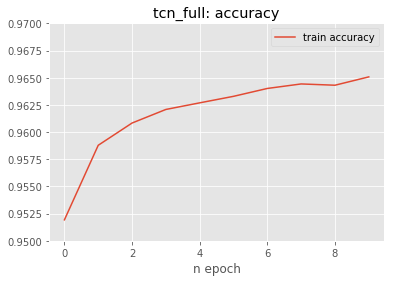

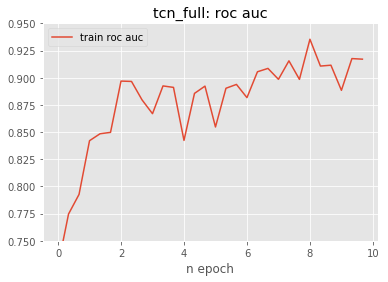

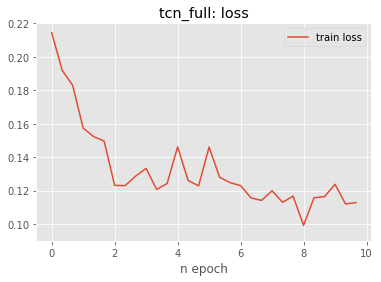

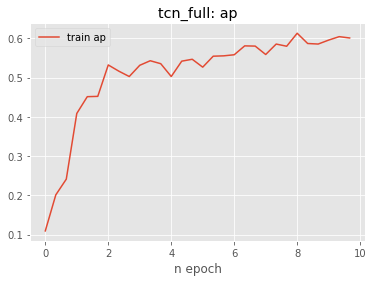

In [153]:
tcn_tmp = tcn_full_5
lst_iter = np.linspace(0, 10, 10, endpoint=False)
train_acc = tcn_tmp.train_metrics.get_metrics()['accuracy_list']
plot_result(lst_iter, train_acc, label='accuracy', title='tcn_full: accuracy', ylim=(0.95, 0.97))
lst_iter = np.linspace(0, 10, 30, endpoint=False)
train_auc = tcn_tmp.train_metrics.get_metrics()['roc_auc_list']
plot_result(lst_iter, train_auc, label='roc auc', title='tcn_full: roc auc', ylim=(0.75, 0.95))
lst_iter = np.linspace(0, 10, 30, endpoint=False)
train_loss = get_loss(tcn_tmp)
plot_result(lst_iter, train_loss, label='loss', title='tcn_full: loss', ylim=(0.09, 0.22))
train_ap = tcn_tmp.train_metrics.average_precision_list
plot_result(lst_iter, train_ap, label='ap', title='tcn_full: ap', ylim=None)

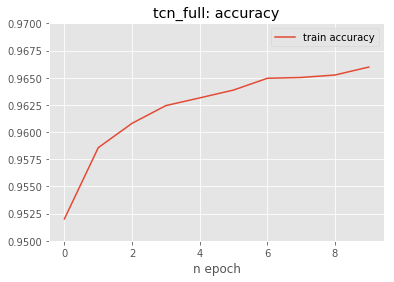

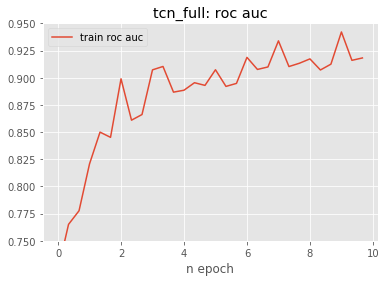

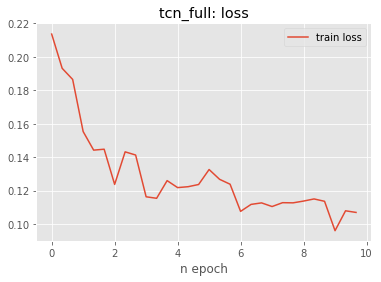

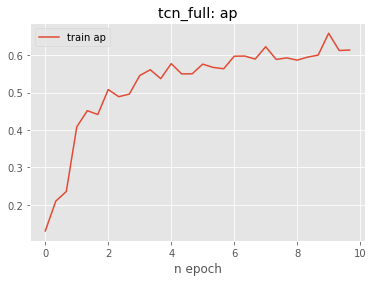

In [154]:
tcn_tmp = tcn_full_6
lst_iter = np.linspace(0, 10, 10, endpoint=False)
train_acc = tcn_tmp.train_metrics.get_metrics()['accuracy_list']
plot_result(lst_iter, train_acc, label='accuracy', title='tcn_full: accuracy', ylim=(0.95, 0.97))
lst_iter = np.linspace(0, 10, 30, endpoint=False)
train_auc = tcn_tmp.train_metrics.get_metrics()['roc_auc_list']
plot_result(lst_iter, train_auc, label='roc auc', title='tcn_full: roc auc', ylim=(0.75, 0.95))
lst_iter = np.linspace(0, 10, 30, endpoint=False)
train_loss = get_loss(tcn_tmp)
plot_result(lst_iter, train_loss, label='loss', title='tcn_full: loss', ylim=(0.09, 0.22))
train_ap = tcn_tmp.train_metrics.average_precision_list
plot_result(lst_iter, train_ap, label='ap', title='tcn_full: ap', ylim=None)

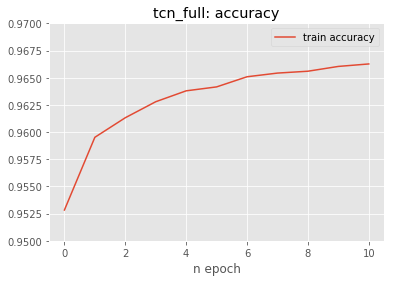

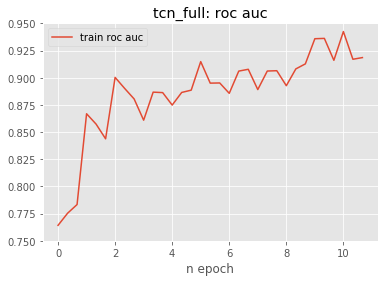

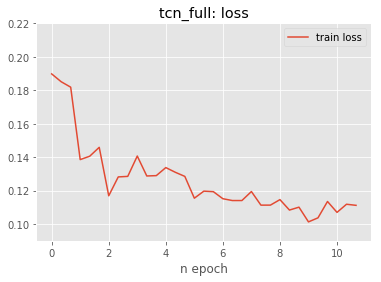

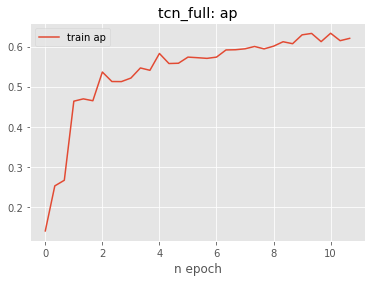

In [155]:
tcn_tmp = tcn_full_7
lst_iter = np.linspace(0, 11, 11, endpoint=False)
train_acc = tcn_tmp.train_metrics.get_metrics()['accuracy_list']
plot_result(lst_iter, train_acc, label='accuracy', title='tcn_full: accuracy', ylim=(0.95, 0.97))
lst_iter = np.linspace(0, 11, 33, endpoint=False)
train_auc = tcn_tmp.train_metrics.get_metrics()['roc_auc_list']
plot_result(lst_iter, train_auc, label='roc auc', title='tcn_full: roc auc', ylim=(0.75, 0.95))
lst_iter = np.linspace(0, 11, 33, endpoint=False)
train_loss = get_loss(tcn_tmp)
plot_result(lst_iter, train_loss, label='loss', title='tcn_full: loss', ylim=(0.09, 0.22))
train_ap = tcn_tmp.train_metrics.average_precision_list
plot_result(lst_iter, train_ap, label='ap', title='tcn_full: ap', ylim=None)

In [8]:
# full
%time tcn_full_3 = torch.load("../model/TCN_CLF_TRANS_basic_3/tcn.pth", map_location=lambda storage, loc: storage)
%time tcn_full_4 = torch.load("../model/TCN_CLF_TRANS_basic_4/tcn.pth", map_location=lambda storage, loc: storage)
%time tcn_full_5 = torch.load("../model/TCN_CLF_TRANS_basic_5/tcn.pth", map_location=lambda storage, loc: storage)
%time tcn_full_6 = torch.load("../model/TCN_CLF_TRANS_basic_6/tcn.pth", map_location=lambda storage, loc: storage) # will go with this one
%time tcn_full_7 = torch.load("../model/TCN_CLF_TRANS_basic_7/tcn.pth", map_location=lambda storage, loc: storage)

CPU times: user 29 ms, sys: 4.29 ms, total: 33.3 ms
Wall time: 32.6 ms
CPU times: user 16.8 ms, sys: 11.5 ms, total: 28.3 ms
Wall time: 28.1 ms
CPU times: user 30.7 ms, sys: 11.6 ms, total: 42.3 ms
Wall time: 42.5 ms
CPU times: user 33.1 ms, sys: 16.4 ms, total: 49.4 ms
Wall time: 48.9 ms
CPU times: user 38.4 ms, sys: 11.9 ms, total: 50.4 ms
Wall time: 50 ms


In [9]:
modeling_df = modeling_df_trans[features].copy()
%time test_data = tcn_full_3.process_data_inference(modeling_df, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])

data processed!
CPU times: user 49.6 s, sys: 404 ms, total: 50 s
Wall time: 49.7 s


In [10]:
%time preds_3 = tcn_full_3.predict_proba(test_data, return_sequences=True)
%time preds_4 = tcn_full_4.predict_proba(test_data, return_sequences=True)
%time preds_5 = tcn_full_5.predict_proba(test_data, return_sequences=True)
%time preds_6 = tcn_full_6.predict_proba(test_data, return_sequences=True)
%time preds_7 = tcn_full_7.predict_proba(test_data, return_sequences=True)

loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
CPU times: user 1min 5s, sys: 8.49 s, total: 1min 14s
Wall time: 48.2 s
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
CPU times: user 1min 1s, sys: 7.65 s, total: 1min 8s
Wall time: 41.1 s
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
CPU times: user 59.6 s, sys: 7.27 s, total: 1min 6s
Wall time: 41.5 s
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
CPU times: user 1min 1s, sys: 7.48 s, total: 1min 9s
Wall time: 42.2 s
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
CPU times: user 1min 5s, sys: 7.75 s, total: 1min 13s
Wall time: 45.3 s


In [20]:
df_tmps = [(preds_3, 'preds_3'), (preds_4, 'preds_4'), (preds_5, 'preds_5'), (preds_6, 'preds_6'), (preds_7, 'preds_7')]
modeling_df_tmp = modeling_df.copy()
for df_tmp, label in df_tmps:
    df_tmp.columns = ['index', 'borrower_id', label]
    modeling_df_tmp = pd.merge(df_tmp, modeling_df_tmp, on=['index', 'borrower_id'], how='inner')

In [23]:
modeling_df_tmp.head()

,index,borrower_id,preds_7,preds_6,preds_5,preds_4,preds_3,nr_past_transactions,card_present_ind,has_transaction_comment,hr_of_transaction,international_transaction_flag,transaction_code,transaction_type,days_since_first_transaction,transaction_as_pct_of_balance,target
0,288486.0,90.0,0.083797,0.095555,0.098225,0.101454,0.107012,0.0,0.0,0.0,18.0,0.0,ACHDD,ACH,0.0,100.000000,0.0
1,319444.0,90.0,0.033688,0.037421,0.046804,0.059320,0.055768,1.0,0.0,0.0,18.0,0.0,ACHDD,ACH,5.0,0.272727,0.0
2,319447.0,90.0,0.024738,0.031352,0.041331,0.041678,0.033298,2.0,0.0,0.0,18.0,0.0,ACHDD,ACH,5.0,10.000000,0.0
3,377332.0,90.0,0.007001,0.009073,0.014787,0.014869,0.015033,3.0,0.0,0.0,18.0,0.0,ACHDD,ACH,13.0,0.928571,0.0
4,479867.0,90.0,0.005099,0.009282,0.008876,0.009953,0.005795,4.0,1.0,0.0,18.0,0.0,DWATM,ATM,28.0,-0.037237,0.0


In [28]:
def plot_pr_curve_mult(y_test, y_scores, title, colors=['b']):
    assert(len(y_scores) == len(colors))
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    aps = []
            
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        average_precision = average_precision_score(y_test, y_score)
        aps.append(average_precision)
        precision, recall, _ = precision_recall_curve(y_test, y_score)

        plt.step(recall, precision, color=colors[i], alpha=0.2,
                 where='post', label=label)
        plt.fill_between(recall, precision, alpha=0.2, color=colors[i])
    
    plt.legend()

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)
    
def plot_pr_curve(y_test, y_score):
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_score)
    
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP = {}'.format(str(average_precision)))

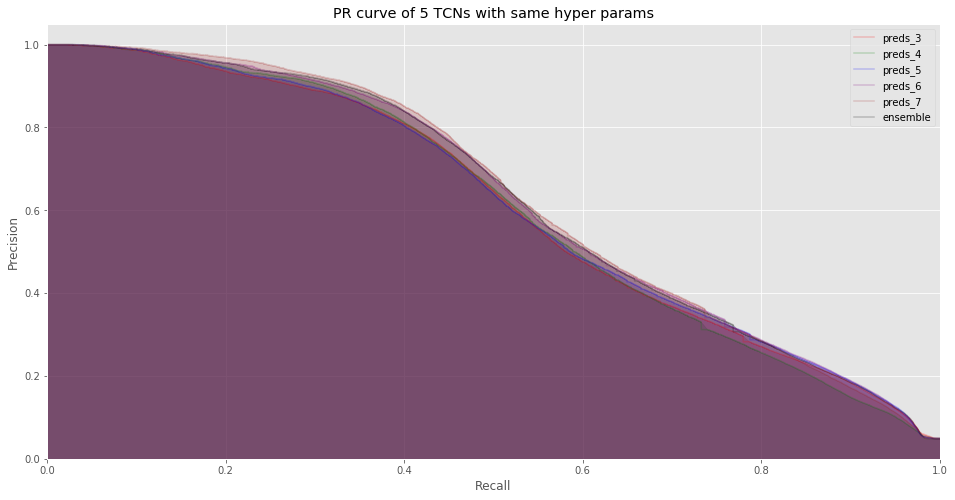

In [27]:
target = modeling_df_tmp.target
ensemble = (modeling_df_tmp['preds_3']+modeling_df_tmp['preds_4']+modeling_df_tmp['preds_5']+modeling_df_tmp['preds_6']+modeling_df_tmp['preds_7'])/5
y_scores = [(modeling_df_tmp.preds_3, 'preds_3'),
            (modeling_df_tmp.preds_4, 'preds_4'),
            (modeling_df_tmp.preds_5, 'preds_5'), 
            (modeling_df_tmp.preds_6, 'preds_6'),
            (modeling_df_tmp.preds_7, 'preds_7'),
            (ensemble, 'ensemble')]

title = 'PR curve of 5 TCNs with same hyper params'
colors = ['r', 'g', 'b', 'purple', 'brown', 'black']
fig = plt.figure(figsize=(16,8))
plot_pr_curve_mult(target, y_scores, title, colors)

### Merge and Output
---

In [ ]:
# account level data
df['borrower_id'] = df['borrower_id'].astype(int)
inference_pred['borrower_id'] = inference_pred['borrower_id'].astype(int)
inference_pred.sort_values(['index', 'transaction_datetime'], inplace=True)
df_acct = pd.merge_asof(df[df.columns[~df.columns.isin(['transaction_datetime'])]], 
                        inference_pred[['lgbm_basic_pred',
                                        'tcn_pred',
                                        'lgbm_all_trans_pred',
                                        'lgbm_prem_trans_w_tcn_pred',
                                        'transaction_type',
                                        'card_present_ind',
                                        'transaction_as_pct_of_balance',
                                        'hr_of_transaction',
                                        'randf',
                                        'transaction_code',
                                        'has_transaction_comment',
                                        'index',
                                        'international_transaction_flag',
                                        'borrower_id', 
                                        'transaction_datetime']], left_on='reporting_date', right_on='transaction_datetime', by='borrower_id')

df_acct['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df_acct['age'] = (pd.datetime.today() - df_acct['date_of_birth']).dt.days

modeling_df_acct = df_acct[~df_acct['latest_acc_bal'].isna() & ~df_acct['is_indeterminate']]
modeling_df_acct = modeling_df_acct.drop_duplicates(subset=['borrower_id', 'reporting_date_id'], keep='first')